In [ ]:
import pandas as pd
import time
from openai import OpenAI
import re
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# load results
gpt4o_results = pd.read_csv("gpt_results_4o.csv")
gpt3_5_results = pd.read_csv("gpt_results_3_5_final.csv")

def calculate_accuracy(df):
    """Calculates the accuracy of GPT predictions."""
    df["correct"] = df["gpt_prediction"] == df["correct_answer"]
    accuracy = df["correct"].mean() * 100
    return accuracy

# calculate accuracy
gpt4o_accuracy = calculate_accuracy(gpt4o_results)
gpt3_5_accuracy = calculate_accuracy(gpt3_5_results)

print(f"GPT-4o Accuracy: {gpt4o_accuracy:.2f}%")
print(f"GPT-3.5 Accuracy: {gpt3_5_accuracy:.2f}%")


GPT-4o Accuracy: 63.00%
GPT-3.5 Accuracy: 49.80%


In [ ]:
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
evaluation_prompt = """
You are an AI assistant evaluating the reasoning quality of another AI model's response.
Given an original post, two counterarguments, and the AI’s explanation, rate the explanation on a scale of 1 to 10 for:
1. **Clarity** (Is the reasoning easy to understand?)
2. **Logical Depth** (Does it consider multiple perspectives and explain deeply?)
3. **Consistency** (Is the reasoning logically structured and non-contradictory?)
4. **Bias Avoidance** (Does the explanation remain neutral and not favor a specific ideology?)
5. **Persuasiveness** (Would this explanation convince a human?)

Provide your scores in **this exact format**:
Clarity: X
Logical Depth: X
Consistency: X
Bias Avoidance: X
Persuasiveness: X

Now evaluate the following:

**Original Post:**
{original_post}

**Counterargument 1:**
{counterargument_1}

**Counterargument 2:**
{counterargument_2}

**AI’s Explanation:**
{explanation}
"""

In [ ]:
os.getenv("OPENAI_API_KEY")

In [ ]:
# function that evaluates the explanations
def evaluate_explanation(row, model="gpt-4o"):
    prompt = evaluation_prompt.format(
        original_post=row["original_post"],
        counterargument_1=row["counterargument_1"],
        counterargument_2=row["counterargument_2"],
        explanation=row["explanation"]
    )

    for attempt in range(3):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "system", "content": "You are an AI evaluating AI explanations."},
                          {"role": "user", "content": prompt}],
                temperature=0.0,
                max_tokens=200
            )

            gpt_output = response.choices[0].message.content.strip()
            scores = {}
            for metric in ["Clarity", "Logical Depth", "Consistency", "Bias Avoidance", "Persuasiveness"]:
                match = re.search(fr"{metric}:\s*(\d+)", gpt_output)
                scores[metric] = int(match.group(1)) if match else None

            return scores

        except Exception as e:
            print(f"API call failed (Attempt {attempt+1}/3): {e}")
            time.sleep(2)

    return {"Clarity": None, "Logical Depth": None, "Consistency": None, "Bias Avoidance": None, "Persuasiveness": None}

# evaluate the explanations in a batch
def batch_evaluate(df, model="gpt-4o"):
    """Runs GPT-based evaluation on all explanations in a df."""
    scores = []
    for i, row in df.iterrows():
        print(f"Evaluating explanation {i+1}/{len(df)}...")
        score = evaluate_explanation(row, model)
        scores.append(score)
        time.sleep(1)
    return pd.DataFrame(scores)

In [ ]:
# run the score evaluation on both result sets
print("\n Evaluating GPT-4o Explanations...")
gpt4o_scores = batch_evaluate(gpt4o_results)

print("\nEvaluating GPT-3.5 Explanations...")
gpt3_5_scores = batch_evaluate(gpt3_5_results)

# save the computed scores
gpt4o_scores.to_csv("gpt4o_explanation_scores.csv", index=False)
gpt3_5_scores.to_csv("gpt3_5_explanation_scores.csv", index=False)


In [15]:
gpt4o_scores = pd.read_csv("gpt4o_explanation_scores.csv")
gpt3_5_scores = pd.read_csv("gpt3_5_explanation_scores.csv")

# function to compute average scores for all the explanation quality metric
def compute_average_scores(df):
    return df.mean().to_frame(name="Average Score")

# get average scores
gpt4o_avg_scores = compute_average_scores(gpt4o_scores)
gpt3_5_avg_scores = compute_average_scores(gpt3_5_scores)

# combine into one df
comparison_df = pd.concat([gpt4o_avg_scores, gpt3_5_avg_scores], axis=1)
comparison_df.columns = ["GPT-4o", "GPT-3.5"]

print(comparison_df)

comparison_df.to_csv("explanation_quality_comparison.csv")


                  GPT-4o   GPT-3.5
Clarity         7.170000  6.565130
Logical Depth   6.154000  5.440882
Consistency     7.230000  6.488978
Bias Avoidance  6.835671  6.305221
Persuasiveness  6.272177  5.721212


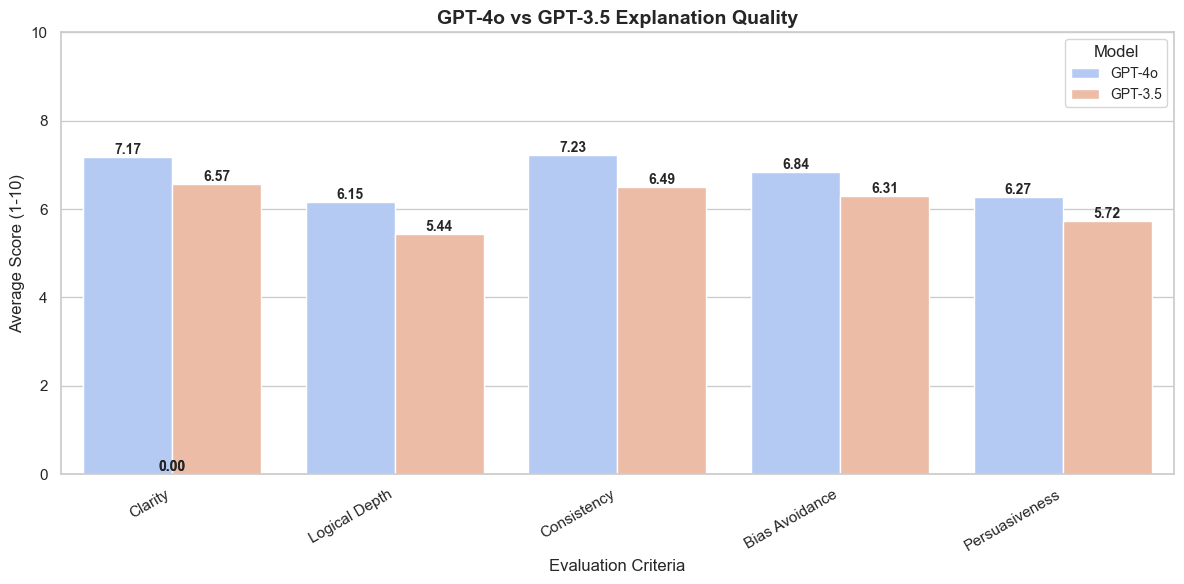

In [24]:


sns.set_theme(style="whitegrid")

comparison_df_melted = comparison_df.reset_index().melt(id_vars="index", var_name="Model", value_name="Score")
comparison_df_melted.rename(columns={"index": "Evaluation Criteria"}, inplace=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=comparison_df_melted,
    x="Evaluation Criteria",
    y="Score",
    hue="Model",
    palette="coolwarm"
)

plt.title("GPT-4o vs GPT-3.5 Explanation Quality", fontsize=14, fontweight="bold")
plt.ylabel("Average Score (1-10)", fontsize=12)
plt.xlabel("Evaluation Criteria", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Model", title_fontsize="12", fontsize="10")
plt.ylim(0, 10)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.savefig('images/exp_quality.png')
plt.show()


In [11]:

gpt4o_results = pd.read_csv("gpt_results_4o.csv")
gpt3_5_results = pd.read_csv("gpt_results_3_5_final.csv")

gpt4o_scores = pd.read_csv("gpt4o_explanation_scores.csv")
gpt3_5_scores = pd.read_csv("gpt3_5_explanation_scores.csv")

# merge explanation scores with prediction results
gpt4o_merged = pd.concat([gpt4o_results, gpt4o_scores], axis=1)
gpt3_5_merged = pd.concat([gpt3_5_results, gpt3_5_scores], axis=1)

gpt4o_merged["correct"] = gpt4o_merged["gpt_prediction"] == gpt4o_merged["correct_answer"]
gpt3_5_merged["correct"] = gpt3_5_merged["gpt_prediction"] == gpt3_5_merged["correct_answer"]



In [18]:
# compute avg explanation scores for correct vs incorrect predictions
def compute_avg_explanation_scores(df):
    explanation_columns = ["Clarity", "Logical Depth", "Consistency", "Bias Avoidance", "Persuasiveness"]

    correct_scores = df[df["correct"]][explanation_columns].mean()
    incorrect_scores = df[~df["correct"]][explanation_columns].mean()

    comparison_df = pd.DataFrame({"Correct Predictions": correct_scores, "Incorrect Predictions": incorrect_scores})
    return comparison_df

gpt4o_explanation_comparison = compute_avg_explanation_scores(gpt4o_merged)
gpt3_5_explanation_comparison = compute_avg_explanation_scores(gpt3_5_merged)

print("\n**GPT-4o Explanation Score Comparison (Correct vs Incorrect Predictions):**")
print(gpt4o_explanation_comparison)

print("\n**GPT-3.5 Explanation Score Comparison (Correct vs Incorrect Predictions):**")
print(gpt3_5_explanation_comparison)

gpt4o_explanation_comparison.to_csv("gpt4o_explanation_accuracy_comparison.csv")
gpt3_5_explanation_comparison.to_csv("gpt3.5_explanation_accuracy_comparison.csv")



**GPT-4o Explanation Score Comparison (Correct vs Incorrect Predictions):**
                Correct Predictions  Incorrect Predictions
Clarity                    7.111111               7.270270
Logical Depth              6.107937               6.232432
Consistency                7.136508               7.389189
Bias Avoidance             6.748408               6.983784
Persuasiveness             6.169872               6.445652

**GPT-3.5 Explanation Score Comparison (Correct vs Incorrect Predictions):**
                Correct Predictions  Incorrect Predictions
Clarity                    6.560484               6.569721
Logical Depth              5.447581               5.434263
Consistency                6.479839               6.498008
Bias Avoidance             6.344130               6.266932
Persuasiveness             5.727642               5.714859


/var/folders/yl/7917snvn4hs5nb_vpc0q99mh0000gn/T/ipykernel_3015/3035753678.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha="right")
/var/folders/yl/7917snvn4hs5nb_vpc0q99mh0000gn/T/ipykernel_3015/3035753678.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha="right")


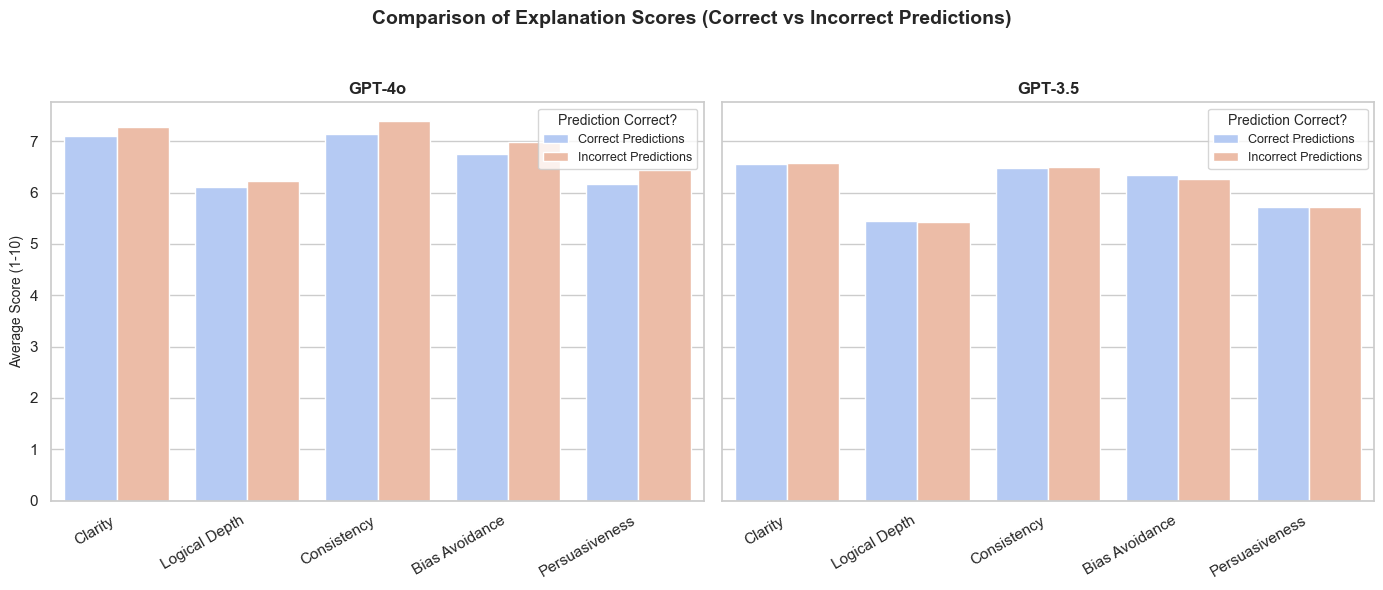

In [25]:
gpt4o_explanation_melted = gpt4o_explanation_comparison.reset_index().melt(
    id_vars="index", var_name="Correctness", value_name="Score"
)
gpt4o_explanation_melted.rename(columns={"index": "Evaluation Criteria"}, inplace=True)

gpt3_5_explanation_melted = gpt3_5_explanation_comparison.reset_index().melt(
    id_vars="index", var_name="Correctness", value_name="Score"
)
gpt3_5_explanation_melted.rename(columns={"index": "Evaluation Criteria"}, inplace=True)


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig.suptitle("Comparison of Explanation Scores (Correct vs Incorrect Predictions)", fontsize=14, fontweight="bold")

# 4o model plot
sns.barplot(
    data=gpt4o_explanation_melted,
    x="Evaluation Criteria",
    y="Score",
    hue="Correctness",
    palette="coolwarm",
    ax=axes[0]
)
axes[0].set_title("GPT-4o", fontsize=12, fontweight="bold")
axes[0].set_ylabel("Average Score (1-10)", fontsize=10)
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha="right")
axes[0].legend(title="Prediction Correct?", fontsize=9, title_fontsize="10")

# 3.5 model plot
sns.barplot(
    data=gpt3_5_explanation_melted,
    x="Evaluation Criteria",
    y="Score",
    hue="Correctness",
    palette="coolwarm",
    ax=axes[1]
)
axes[1].set_title("GPT-3.5", fontsize=12, fontweight="bold")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha="right")
axes[1].legend(title="Prediction Correct?", fontsize=9, title_fontsize="10")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("images/gpt4o_explanation_accuracy_comparison.png")
plt.show()